In [1]:
!pip install transformers

In [2]:
import transformers 
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns

<Axes: xlabel='count', ylabel='sentiment'>

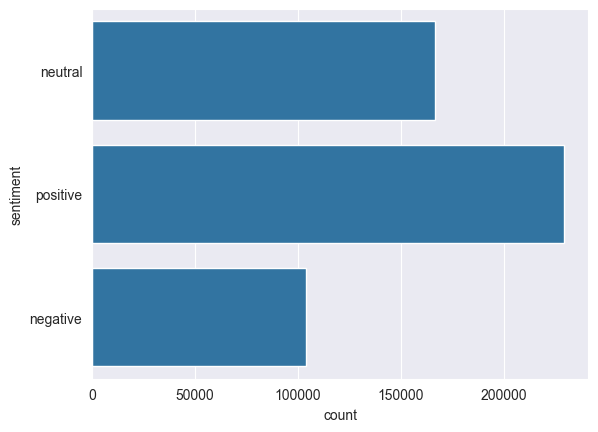

In [3]:
import pandas as pd
df = pd.read_json("feature_engineered_dataset.json", lines=True)
sns.countplot(df.sentiment)

In [4]:
df = df.sample(25000)
print("SHAPE::",df.shape)

SHAPE:: (25000, 10)


In [5]:
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment
264037,bbKKfTVLcfwGpd8VFfzXCg,MumjV_uAIvMvLp2EofTXfA,G8dNtoaJZ-_ulOL37pZNNA,5,0,0,0,I was very impressed with this place. The serv...,2018-09-10 23:30:45,positive
266469,yh5-G2QHMQ_mGw85qMEixg,_m5LRWBLY561gT9b3yUoIA,HX3UAADrWMqReSRIrKteOA,1,3,0,0,*AVOID* Not only did they cut my nail down so ...,2017-06-12 20:55:32,negative
230957,YmBLzRDoAtX1uWw47UZqaA,HaidkMWMgaXq-Yquq099cQ,bXjnfT69E8DJinX-ifOofA,2,0,0,0,"So, i wrote a review in January of 2017. i ju...",2017-01-01 21:36:59,negative
238731,PtiCatJ9Le3gG10xI_RJRg,6Q8dQGr_DBKcmQ1aXVWvTQ,MF5-JPr0auUkY_WLTTVUaA,4,3,0,1,Ended up here unexpectedly. The original place...,2018-03-31 03:15:21,neutral
448453,EZy6S9Q35b5x0Ope0vdWvQ,Y_Aj3fX2JlJh9glH5LX6VA,A3vvP7tuNU5Tj2qII6fJIw,4,1,0,1,"Super flavorful! We started with an empenada,...",2009-12-03 20:50:50,neutral


In [6]:
class_name = ['negative','neutral', 'positive']

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
device

device(type='cpu')

In [9]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [10]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

100%|██████████| 25000/25000 [00:31<00:00, 791.37it/s]
C:\Users\HP\AppData\Local\Temp\ipykernel_2580\1894350238.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


<Axes: ylabel='Density'>

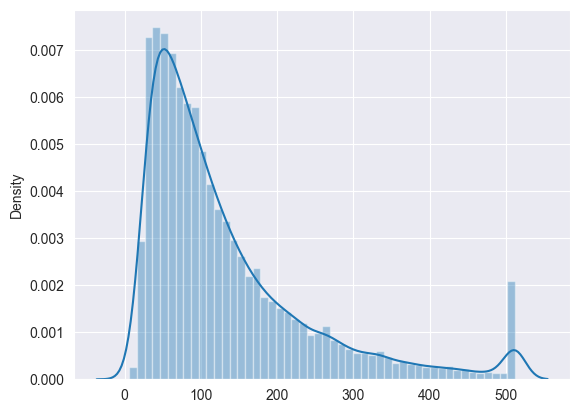

In [11]:
from tqdm import tqdm
token_lens = []
for txt in tqdm(df.text):
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)

In [12]:
MAX_LEN = 120

In [13]:
from torch.utils.data import Dataset, DataLoader
class ReviewDataset(Dataset):
    def __init__(self,reviews,targets,tokenizer,max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self,item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
            }

In [14]:
from sklearn.model_selection import train_test_split

# Define the features and target variable
X = df.drop('sentiment', axis=1)
y = df['sentiment']

# Split the data into training, validation, and test sets
# The stratify parameter ensures that the class distribution is similar in each split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Create DataFrames for each split
df_train = pd.concat([X_train, y_train], axis=1)
df_val = pd.concat([X_val, y_val], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

# Optional: Check the distribution of sentiment in each split
print("Sentiment Distribution in Training Set:")
print(df_train['sentiment'].value_counts())

print("\nSentiment Distribution in Validation Set:")
print(df_val['sentiment'].value_counts())

print("\nSentiment Distribution in Test Set:")
print(df_test['sentiment'].value_counts())

Sentiment Distribution in Training Set:
sentiment
positive    6832
neutral     5037
negative    3131
Name: count, dtype: int64

Sentiment Distribution in Validation Set:
sentiment
positive    2277
neutral     1679
negative    1044
Name: count, dtype: int64

Sentiment Distribution in Test Set:
sentiment
positive    2277
neutral     1680
negative    1043
Name: count, dtype: int64


In [15]:
df_train.shape, df_val.shape, df_test.shape

((15000, 10), (5000, 10), (5000, 10))

In [16]:
from sklearn.utils import class_weight

target_variable = 'sentiment'

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(df[target_variable].values),
                                                 y=df[target_variable].values)

In [17]:
class_weights

array([1.5970359 , 0.99253613, 0.73189297])

In [18]:
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds = ReviewDataset(
        text = df.text.to_numpy(), 
        targets = df.sentiment.to_numpy(),
        tokenizer = tokenizer,
        max_len=max_len)

    return DataLoader(ds,
                      batch_size=batch_size,
                      num_workers=4)

In [19]:
from torch.utils.data import Dataset, DataLoader
import torch

class SentimentDataset(Dataset):
    def __init__(self, text, targets, tokenizer, max_len):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = SentimentDataset(
        text=df['text'].to_numpy(),
        targets=df['sentiment'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=4)

# Assuming you have the tokenizer and MAX_LEN defined
BATCH_SIZE = 32
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [20]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [21]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.4)
    #self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.out1 = nn.Linear(self.bert.config.hidden_size, 128)
    self.drop1 = nn.Dropout(p=0.4)
    self.relu = nn.ReLU()
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    #output = self.relu(pooled_output)
    output = self.drop(pooled_output)
    output = self.out1(output)
    output = self.relu(output)
    output = self.drop1(output)
    return self.out(output)

In [22]:
model = SentimentClassifier(len(class_name))
model = model.to(device)

In [23]:
EPOCHS = 2
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
#class_weights = torch.FloatTensor(class_weights).to(device)
#weight=class_weights
loss_fn = nn.CrossEntropyLoss().to(device)

C:\Users\HP\PycharmProjects\deep-learning-coursework\venv\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)


In [25]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name))

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)

In [ ]:
review_text = "Love the place and love the food"


In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_name[prediction]}')